In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyproj import Proj, CRS, Transformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import gpytorch
import rasterio
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.kernels import CMEAggregateKernel
from src.means import CMEAggregateMean
from src.models import VariationalCMEProcess
from src.likelihoods import CMEProcessLikelihood
from src.structures import BagDataset

def list_collate(batch):
    data, target = zip(*batch)
    return list(data), torch.Tensor(target)

def process(array, qmin=1, qmax=99):
    normalize = lambda x: (x - x.min(axis=(0, 1))) / (x.max(axis=(0, 1)) - x.min(axis=(0, 1)))
    upper_bound = np.percentile(array, q=qmax, axis=(0, 1))
    lower_bound = np.percentile(array, q=qmin, axis=(0, 1))
    array = array.clip(min=lower_bound, max=upper_bound)
    array = normalize(array)
    return array

In [3]:
# Load aerobag dataframe
df_path = '../../aerobag-dataset/sandbox/aerobag-01-04-20.csv'
df = pd.read_csv(df_path, index_col='index')

df.sample(n=5)

,Unnamed: 0,MODIS_Longitude(Degree),MODIS_Latitude(Degree),b01,b02,b03,b04,b05,b06,b07,...,SolarZenith,AERONET_Site_Name,AERONET_Instrument_Number,Day_of_Year,Data_Quality_Level,Site_Longitude(Degrees),Site_Latitude(Degrees),Site_Elevation(m),AOD_500nm,bag_index
index,,,,,,,,,,,,,,,,,,,,,
155,8082,24.912780,60.316572,629.0,627.0,594.0,575.0,734.0,680.0,360.0,...,5557.0,Helsinki,392,92,lev20,24.960650,60.203733,52.8,0.071888,19
50,1715,2.731272,39.650102,941.0,2152.0,978.0,973.0,2384.0,1976.0,1204.0,...,4158.0,Palma_de_Mallorca,418,92,lev20,2.625100,39.553300,10.0,0.202752,6
472,9176,2.106455,48.801639,1240.0,3123.0,563.0,1056.0,2994.0,2614.0,2028.0,...,4420.0,Paris,648,92,lev20,2.355508,48.846797,50.0,0.124775,22
199,199,-1.262843,44.651836,2225.0,2218.0,2081.0,2235.0,2168.0,2487.0,2258.0,...,4014.0,Arcachon,741,92,lev20,-1.163222,44.663528,11.0,0.138296,1
98,8802,2.234087,48.826639,828.0,1396.0,518.0,756.0,1635.0,1524.0,1304.0,...,4412.0,Paris,648,92,lev20,2.355508,48.846797,50.0,0.124775,22


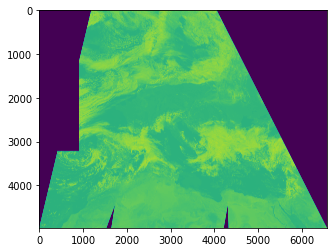

In [4]:
# Load raster
raster = rasterio.open('../../aerobag-dataset/sandbox/MODIS.tif')
b01 = raster.read(1)
plt.imshow(b01)
plt.show()

In [5]:
# Get sites and bags coordinates
WGS84 = rasterio.crs.CRS.from_epsg(4326)
wgs84_to_raster_crs = Transformer.from_proj(WGS84, raster.crs, always_xy=True).transform
to_pixel = lambda row: ~raster.transform * wgs84_to_raster_crs(row[0], row[1])


sites_df = df[['Site_Longitude(Degrees)', 'Site_Latitude(Degrees)']].drop_duplicates()
bags_df = df[['MODIS_Longitude(Degree)', 'MODIS_Latitude(Degree)']]

sites_pixels = sites_df.apply(to_pixel, axis=1).values
sites_pixels = np.asarray(list(map(list, sites_pixels)))

bags_pixels = bags_df.apply(to_pixel, axis=1).values
bags_pixels = np.asarray(list(map(list, bags_pixels)))

### Preprocess data

- Normalize
- Filter out columns

In [6]:
# Normalize
norm_df = (df - df.mean()) / df.std()

In [7]:
# Select features of interest to keep in dataset
individuals_columns = ['MODIS_Longitude(Degree)', 'MODIS_Latitude(Degree)',
                       'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'SensorAzimuth',
                       'SensorZenith', 'SolarAzimuth', 'SolarZenith']
bags_columns = ['Site_Longitude(Degrees)', 'Site_Latitude(Degrees)']
augmented_columns = individuals_columns + bags_columns

# Compute number of bags and their respective sizes
n_bags = df['bag_index'].max()
bags_sizes = df.groupby('bag_index').count()['AOD_500nm'].values

# Extract individuals (augmented with bags values) and aggregate targets
individuals = [norm_df[df.bag_index == idx][augmented_columns].values for idx in df.bag_index.unique()]
aggregate_targets = norm_df.AOD_500nm.drop_duplicates().values

# Instantiate bag dataset
dataset = BagDataset(bags=individuals, labels=aggregate_targets)
dataset

Number of bags : 29 
Dimensionality : 15 
Number of individuals : 13204 
Data type : float64

### Instantiate Varitiational CME Process

In [8]:
# Define mean and covariance modules
individuals_mean = gpytorch.means.ZeroMean()
individuals_kernel = gpytorch.kernels.LinearKernel(active_dims=torch.arange(13), 
                                                   ard_num_dims=13)
bag_kernel = gpytorch.kernels.LinearKernel(active_dims=torch.arange(2), 
                                           ard_num_dims=2)

In [30]:
# Create training set tensors
individuals_tensors = torch.from_numpy(norm_df[individuals_columns].values).float()
bags_tensor = torch.from_numpy(norm_df[bags_columns].drop_duplicates().values).float()
aggregate_targets_tensor = torch.from_numpy(aggregate_targets).float()

In [40]:
raster_array = raster.read()

In [60]:
# Create evenly spaced grid of landmark points
raster_crs_to_wgs84 = Transformer.from_proj(raster.crs, WGS84, always_xy=True).transform


x = np.linspace(0, raster.height, 100).clip(min=0, max=raster.height - 1).astype(int)
y = np.linspace(0, raster.width, 100).clip(min=0, max=raster.width - 1).astype(int)

# raster_array = None
landmark_pixels = raster_array[:, x, y]

In [86]:
# Load QA raster
qa_raster = rasterio.open('../../MODIS/MOD09GA.006_state_1km_1_doy2020092_aid0001.tif')
qa_array = qa_raster.read(1)
CLEAN_PIXELS = [int('{:014b}'.format(i) + '00', 2) for i in range(1 << 14)]

In [66]:
landmark_pixels = raster_array[:, x, y]

In [71]:
pixels_mean = df.mean()[individuals_columns[2:]].values
pixels_std = df.std()[individuals_columns[2:]].values

(11,)

In [76]:
coords = [raster_crs_to_wgs84(*raster.transform * (i, j)) for (i, j) in zip(x, y)]

In [74]:
# Create evenly spaced grid of landmark points
raster_crs_to_wgs84 = Transformer.from_proj(raster.crs, WGS84, always_xy=True).transform

lon_min, lat_min = raster_crs_to_wgs84(*raster.transform * (0, 0))
lon_max, lat_max = raster_crs_to_wgs84(*raster.transform * raster.shape)

lons = torch.linspace(lon_min, lon_max, 10)
lats = torch.linspace(lat_min, lat_max, 10)

landmark_points = torch.stack(torch.meshgrid(lons, lats), dim=-1).view(-1, 2)

In [31]:
# Instantiate model
model = VariationalCMEProcess(landmark_points=landmark_points,
                              individuals_mean=individuals_mean, 
                              individuals_kernel=individuals_kernel,
                              bag_kernel=bag_kernel,
                              train_individuals=individuals_tensors,
                              train_bags=bags_tensor,
                              train_aggregate_targets=aggregate_targets_tensor,
                              bags_sizes=bags_sizes,
                              lbda=1e-3)

likelihood = CMEProcessLikelihood()

### MLE Estimate of model parameters

In [34]:
epochs = 50

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=0.1)

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(individuals))


epoch_iter = tqdm.tqdm(range(epochs), desc="Epoch")
for epoch in epoch_iter:
    optimizer.zero_grad()
    
    q = model(individuals_tensors)
    buffer = model.get_elbo_computation_parameters()
    cme_aggregate_covar, individuals_to_cme_covar, root_inv_individuals_covar = buffer
    
    loss = -elbo(variational_dist_f=q, 
                 target=aggregate_targets_tensor,
                 cme_aggregate_covar=cme_aggregate_covar,
                 individuals_to_cme_covar=individuals_to_cme_covar,
                 root_inv_individuals_covar=root_inv_individuals_covar)

    loss.backward()
    optimizer.step()
    epoch_iter.set_postfix(loss=loss.item())

    with torch.no_grad():
        model.update_cme_estimate_parameters()

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Got 2 and 13 in dimension 1 (The offending index is 1)